In [4]:
from ast import parse
import jittor as jt
from jittor import nn
from jittor.lr_scheduler import CosineAnnealingLR, MultiStepLR
from matplotlib.pyplot import plot

import datasets
from datasets.dataloader import *

import models
from models.model import *
from models.transformer import *

import tools
from tools.train import train_one_epoch
from tools.test import *

import os
import json

jt.flags.use_cuda = 1
jt.set_global_seed(648)

# 加载模型
def build_model(model_type):
    if model_type == "ConvMixer":
        model = ConvMixer_768_32()
    elif model_type == "MLPMixer":
        model = MLPMixer_S_16()
    elif model_type == "VIT":
        model = vit_small_patch16_224()
    else:
        raise NotImplementedError("model type {model_type} is not supported right now\n")
    
    return model
    
    
    
    

[i 0403 11:39:41.768581 48 compiler.py:949] Jittor(1.3.1.53) src: /usr/local/lib/python3.7/dist-packages/jittor
[i 0403 11:39:41.774301 48 compiler.py:950] g++ at /usr/bin/g++(7.5.0)
[i 0403 11:39:41.775148 48 compiler.py:951] cache_path: /root/.cache/jittor/jt1.3.1/g++7.5.0/py3.7.5/Linux-5.4.0-96x21/IntelRXeonRCPUx84/default
[i 0403 11:39:41.781016 48 __init__.py:411] Found /usr/local/cuda/bin/nvcc(10.2.89) at /usr/local/cuda/bin/nvcc.
[i 0403 11:39:41.787588 48 __init__.py:411] Found addr2line(2.30) at /usr/bin/addr2line.
[i 0403 11:39:41.902027 48 compiler.py:1004] cuda key:cu10.2.89_sm_61
[i 0403 11:39:42.086143 48 __init__.py:227] Total mem: 219.71GB, using 16 procs for compiling.
[i 0403 11:39:42.237681 48 jit_compiler.cc:28] Load cc_path: /usr/bin/g++
[i 0403 11:39:42.525243 48 init.cc:62] Found cuda archs: [61,]
[i 0403 11:39:42.697168 48 __init__.py:411] Found mpicc(2.1.1) at /usr/bin/mpicc.
[i 0403 11:39:42.839764 48 compile_extern.py:30] found /usr/include/cublas.h
[i 0403 1

In [5]:
args = {
    'model_name': 'VIT', 
    'epoch_num': 100, 
    'learning_rate': 0.003, 
    'weight_decay': 0.0001, 
    'save_model': False, 
    'save_dir': './log/ViT_lr0.0001/', 
    'load_from_checkpoint': './log/ViT_lr0.0001/', 
    'test': True
}


model = build_model(args["model_name"])
# 从checkpoint中加载
if args["load_from_checkpoint"] != None:
    model.load(args["load_from_checkpoint"] + "model_best.pkl")


modelname = "VIT"
idx2label = testdataset.classes
model.eval()
total_acc = 0
total_num = 0

feature_dict = {}
attn_dict = {}
image_dict = {}

total_labels = 102
matrix = np.zeros((total_labels,total_labels)) # [实际][预测]
for i in range(total_labels): # label -> [feature vectors]
    feature_dict[i] = []
    attn_dict[i] = []
    image_dict[i] = []

plt.figure(figsize=(30, 30))

pbar = tqdm(testdataset, desc=f'Testing')
for i, (images, labels) in enumerate(pbar):
    
    # add feature vector return
    output, feature, attn_weights = model(images, True, True)

    pred = np.argmax(output.data, axis=1)
    acc = np.sum(pred == labels.data)
    total_acc += acc
    total_num += labels.shape[0]

    pbar.set_description(f'Test acc={total_acc / total_num:.2f}')
    
    _pred = idx2label[pred[0]]
    _label = idx2label[labels.data[0]]
    matrix[(int)(_label)][(int)(_pred)] += 1 # 混淆矩阵

    if (int)(_label) in [3,87,74,75,93,50,55,57,43,17,82,42,5,84,89,73,10,62,64,70,45,4]:
        feature_dict[(int)(_label)].append(feature[:, 0])

    if (int)(_label) in [3, 55, 42, 62]:
        attn_dict[(int)(_label)].append(attn_weights)
        image_dict[(int)(_label)].append(images)

    
# calculate_prec_recall(matrix=matrix, total_labels=total_labels, model_name=modelname, plot=False)
# plot_heatmap(matrix=matrix, model_name=modelname)


    

Test acc=0.36: 100%|██████████| 6149/6149 [02:18<00:00, 44.54it/s]


<Figure size 2160x2160 with 0 Axes>

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 20

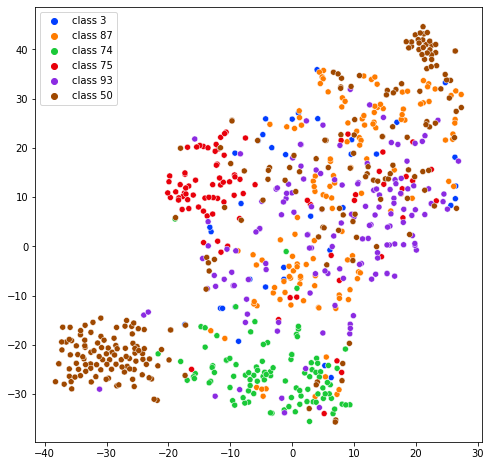

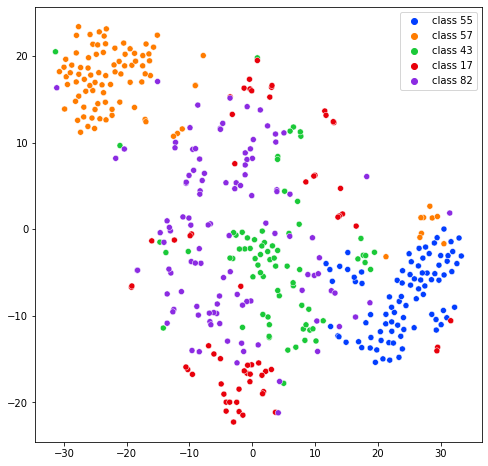

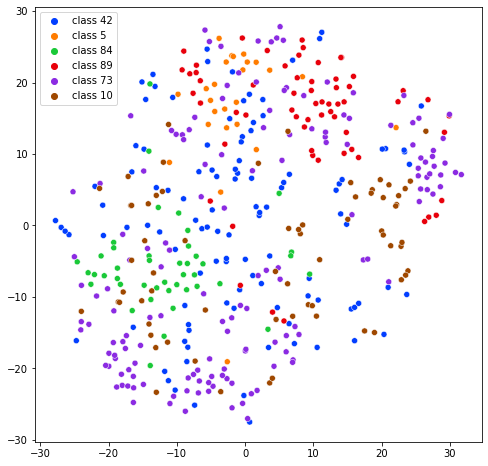

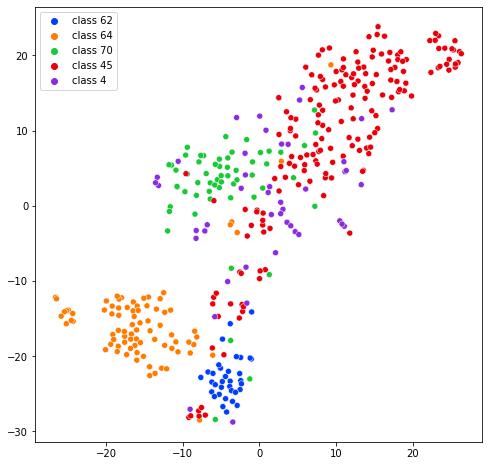

In [6]:

# plot features of different task groups
plot_feature(feature_dict, [3,87,74,75,93,50], tag="FP_worst")
plot_feature(feature_dict, [55,57,43,17,82], tag="FP_best")
plot_feature(feature_dict, [42,5,84,89,73,10], tag="FN_worst")
plot_feature(feature_dict, [62,64,70,45,4], tag="FN_best")

8
0
1
2
3
4
5
6
7
8
0
1
2
3
4
5
6
7
8
0
1
2
3
4
5
6
7
8
0
1
2
3
4
5
6
7
8
0
1
2
3
4
5
6
7
8
0
1
2
3
4
5
6
7
8
0
1
2
3
4
5
6
7
8
0
1
2
3
4
5
6
7


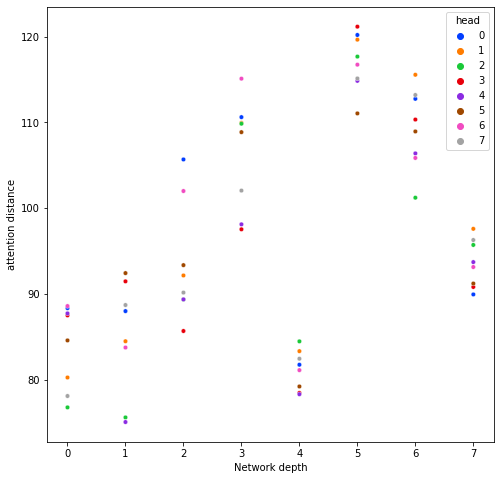

In [7]:
# plot attention distance for class 3, 55, 42, 62
plot_attention_distance(attn_dict=attn_dict, class_label=3, num=1)
# plot_attention_distance(attn_dict=attn_dict, class_label=55, num=1)
# plot_attention_distance(attn_dict=attn_dict, class_label=42, num=1)
# plot_attention_distance(attn_dict=attn_dict, class_label=62, num=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


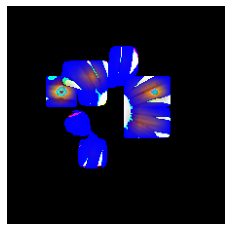

In [8]:
# plot attention rollouts for class 3, 55, 42, 62
plot_attention_rollout(image_dict=image_dict, attn_dict=attn_dict, class_label=3, num=2)
plot_attention_rollout(image_dict=image_dict, attn_dict=attn_dict, class_label=55, num=2)
plot_attention_rollout(image_dict=image_dict, attn_dict=attn_dict, class_label=42, num=2)
plot_attention_rollout(image_dict=image_dict, attn_dict=attn_dict, class_label=62, num=2)